# Reading and cleaning bike trip history data

This notebook includes initial exploration of the bike trip history data. Specifically, it was used to:
1. Develop code for reading tripdata.zip files and selecting features available at the start of the trip
2. Initial exploratory analysis of these features (to identify potential issues in the data).

In [1]:
import datetime
import pandas as pd
import numpy as np

In [2]:
columns = ['Trip Duration',
           'Start Time',
           'Start Station ID',
           'Start Station Latitude',
           'Start Station Longitude',
           'User Type',
           'Birth Year',
           'Gender']
df = pd.read_csv('./../data/raw/201612-citibike-tripdata.zip', parse_dates=[1], usecols=columns)

In [3]:
df['Day of Week'] = df['Start Time'].dt.dayofweek
df['Hour'] = df['Start Time'].dt.hour
df['Month'] = df['Start Time'].dt.month

In [4]:
df.head()

,Trip Duration,Start Time,Start Station ID,Start Station Latitude,Start Station Longitude,User Type,Birth Year,Gender,Day of Week,Hour,Month
0,528,2016-12-01 00:00:04,499,40.769155,-73.981918,Subscriber,1964.0,1,3,0,12
1,218,2016-12-01 00:00:28,3418,40.675021,-73.971115,Subscriber,1955.0,1,3,0,12
2,399,2016-12-01 00:00:39,297,40.734232,-73.986923,Subscriber,1985.0,1,3,0,12
3,254,2016-12-01 00:00:44,405,40.739323,-74.008119,Subscriber,1982.0,1,3,0,12
4,1805,2016-12-01 00:00:54,279,40.707873,-74.001670,Subscriber,1989.0,1,3,0,12


In [5]:
df.describe()

,Trip Duration,Start Station Latitude,Start Station Longitude,Birth Year,Gender,Day of Week,Hour,Month
count,8.121920e+05,812192.000000,812192.000000,772488.000000,812192.000000,812192.000000,812192.000000,812192.0
mean,7.759573e+02,40.737667,-73.984587,1977.099969,1.161004,2.806270,13.577580,12.0
std,7.542199e+03,0.082664,0.143095,11.999981,0.489375,1.802958,4.816329,0.0
min,6.100000e+01,0.000000,-74.031372,1885.000000,0.000000,0.000000,0.000000,12.0
25%,3.340000e+02,40.721101,-73.995101,1969.000000,1.000000,1.000000,9.000000,12.0
50%,5.330000e+02,40.739445,-73.987216,1979.000000,1.000000,3.000000,14.000000,12.0
75%,8.760000e+02,40.756014,-73.976485,1987.000000,1.000000,4.000000,17.000000,12.0
max,3.473103e+06,40.804213,0.000000,2000.000000,2.000000,6.000000,23.000000,12.0


Issues identified include:
- 0 lat/long records.
- Unreasonable birth years

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/Users/benjaminjakubowski/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


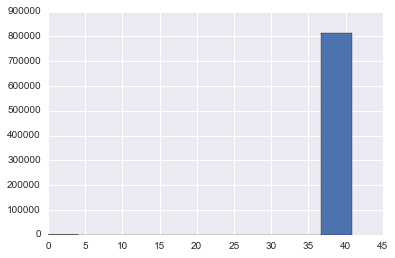

In [7]:
hist = plt.hist(df['Start Station Latitude'])

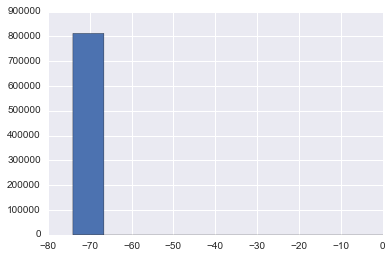

In [8]:
hist = plt.hist(df['Start Station Longitude'])

We filter out these records using a simply threshold, though with additional time a more rigorous bounding box or bounding polygon test could be used.

In [9]:
print df.shape
df = df.loc[df['Start Station Longitude'] < -65, :]
print df.shape
df = df.loc[df['Start Station Latitude'] > 35, :]
print df.shape

(812192, 11)
(812189, 11)
(812189, 11)


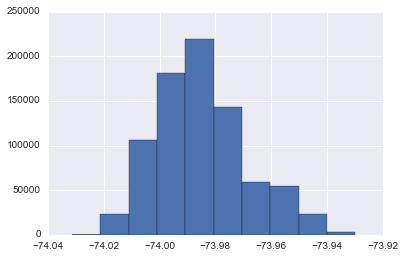

In [10]:
hist = plt.hist(df['Start Station Longitude'])

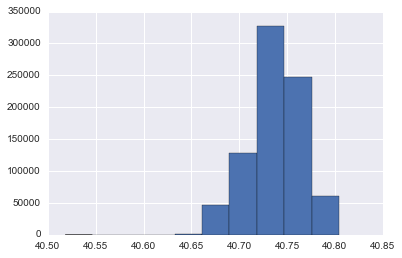

In [11]:
hist = plt.hist(df['Start Station Latitude'])

Next we consider the age distribution:

In [12]:
np.sum(df['Birth Year'].isnull())

39704

There are 39704 missing values, but also a number that are unreasonable:

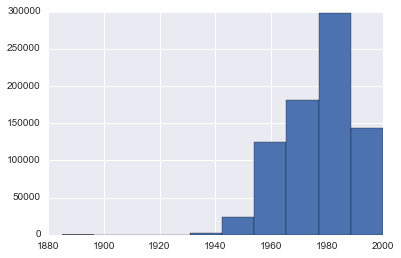

In [13]:
hist = plt.hist(df.loc[~df['Birth Year'].isnull(), 'Birth Year'])

Again applying a heuristic threshold, we'll classify any Birth Year <= 1920 as NaN.

In [14]:
df['Birth Year'] = df['Birth Year'].apply(lambda x: x if x > 1920 else np.NaN)

In [15]:
np.sum(df['Birth Year'].isnull())

40002

Finally, we'll fill the missing birth year's using the mean value for each station, and add a "missing" dummy. Note this again is a simple approach, and given additional time alternate approaches could be considered.

In [16]:
mean_year_by_station = df.groupby('Start Station ID').agg({'Birth Year':np.mean})

In [17]:
df['Age Missing'] = df['Birth Year'].isnull().astype(int) #Note we'll use Age instead of birthyear

In [18]:
mean_year_by_station.head()

,Birth Year
Start Station ID,
116,1977.585949
119,1975.762195
120,1978.773050
127,1976.155488
128,1978.778722


In [19]:
df = pd.merge(df, mean_year_by_station, how='left', left_on='Start Station ID', right_index=True)

In [20]:
df['Birth Year'] = df['Birth Year_x'].fillna(df['Birth Year_y'])

In [21]:
df.drop(['Birth Year_x', 'Birth Year_y'], axis=1, inplace=True)

In [22]:
df.count()

Trip Duration              812189
Start Time                 812189
Start Station ID           812189
Start Station Latitude     812189
Start Station Longitude    812189
User Type                  806801
Gender                     812189
Day of Week                812189
Hour                       812189
Month                      812189
Age Missing                812189
Birth Year                 812189
dtype: int64

Finally, note there are missing User Types- this is fine, since we'll encode that as a missing dummy.

Finally, we'll convert "Birth Year" into an "Age" feature.

In [23]:
df['Age'] = df['Start Time'].dt.year - df['Birth Year']

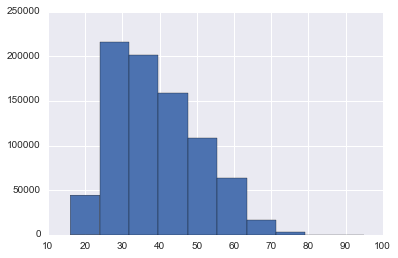

In [24]:
hist = plt.hist(df['Age'])

In [25]:
df.drop('Birth Year',axis=1, inplace=True)

In [26]:
df.count()

Trip Duration              812189
Start Time                 812189
Start Station ID           812189
Start Station Latitude     812189
Start Station Longitude    812189
User Type                  806801
Gender                     812189
Day of Week                812189
Hour                       812189
Month                      812189
Age Missing                812189
Age                        812189
dtype: int64

Finally, we'll make dummies for string feature (User Type) and drop lat/long features. Note we will not make dummies for integer-index categorical variables, as we can use sklearn's OneHotEncoder.

In [27]:
users = pd.get_dummies(df['User Type'], dummy_na=True)
users.columns = list(users.columns[0:2]) + ['User Type Missing']
df = df.join(users)

In [28]:
df.drop(['Start Station Latitude', 'Start Station Longitude', 'User Type'], axis=1, inplace=True)

In [29]:
df.count()

Trip Duration        812189
Start Time           812189
Start Station ID     812189
Gender               812189
Day of Week          812189
Hour                 812189
Month                812189
Age Missing          812189
Age                  812189
Customer             812189
Subscriber           812189
User Type Missing    812189
dtype: int64